In [1]:
import torch
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

# Simulating the sigmoid cohort

In [63]:
# logistic sampler from individidual parameters

def logistic(timepoints, acceleration, timeshift, a=0, b=1, spaceshift=None, noise=None):
    """
    - timepoints : real ages of patients at which we want the visits
    - acceleration : feature wise acceleration factor
    - timeshift : feature wise timeshift (point at which the logistic curves hits a fixed value across features)
    - a,b : first asymptote and second asymptote. By default features go from 0 to 1
    """
    L = np.exp(acceleration)/10*(timepoints - timeshift)
    if noise is not None:
        L = L+noise
    if spaceshift is not None:
        return a + (b-a)/(1+np.exp(-L + spaceshift/20)) 
    return a + (b-a)/(1+np.exp(-L))

def sum_logistic(timepoints, acceleration, timeshift, a=0, b=1, spaceshift=None):
    """
    - timepoints : real ages of patients at which we want the visits
    - acceleration : feature wise acceleration factor
    - timeshift : feature wise timeshift (point at which the logistic curves hits a fixed value across features)
    - a,b : first asymptote and second asymptote. By default features go from 0 to 1
    """
    Lp = np.exp(acceleration)/3*(np.array(timepoints) - np.array(timeshift)) + 5
    Lm = np.exp(acceleration)/3*(np.array(timepoints) - np.array(timeshift)) - 5
    if spaceshift is not None:
        return a + (b-a)/(1+np.exp(-Lp + spaceshift/3))/2 + (b-a)/(1+np.exp(-Lm + spaceshift/3))/2
    return  a + (b-a)/(1+np.exp(-Lp))/2 + (b-a)/(1+np.exp(-Lm))/2

No handles with labels found to put in legend.


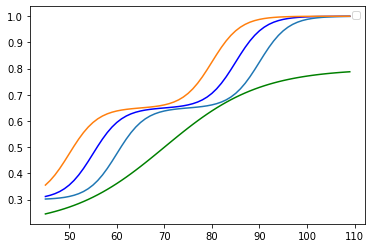

In [80]:
t = np.arange(45,110,1)

#t = np.array([50,50.5,51,52,53])
p1 = logistic(t, 0, 70, 0.2, 0.8, spaceshift=0)
p2 = sum_logistic(t, 0, 70, 0.3, 1, spaceshift=0) 
p1_source_neg = logistic(t, 0, 70, 0.2, 0.8, 5)
p2_source_neg = sum_logistic(t, 0, 70, 0.3, 1, -5) 
p1_source_pos = logistic(t, 0, 70, 0.2, 0.8, -5)
p2_source_pos = sum_logistic(t, 0, 70, 0.3, 1, 5) 
p3 = logistic(t, -1.2, 35 )

plt.plot(t,p1,c='g')
plt.plot(t,p2,c='b')
plt.plot(t,p2_source_pos)
plt.plot(t,p2_source_neg)
#plt.plot(t,p3,c='r')
plt.legend()
plt.show()


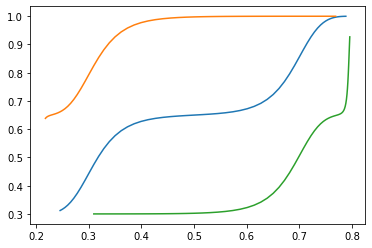

In [62]:
plt.plot(p1,p2)
plt.plot(p1_source_neg,p2_source_neg)
plt.plot(p1_source_pos,p2_source_pos)

In [81]:
# generation of the individual parameters

n_patients = 200

# individual_parameters
xi_mean = 0
sigma_xi = 0.5
tau_mean = 70
sigma_tau = 12
sources_std = 10

columns = ['xi', 'tau', 'source']
feature_parameters = pd.DataFrame(columns=columns)

for i in range(n_patients):
    xi = np.random.normal(xi_mean, sigma_xi)
    tau = np.random.normal(tau_mean, sigma_tau)
    source = np.random.normal(0,sources_std)
    feature_parameters.loc[i] = [xi, tau, source]
    
feature_parameters.head()

,xi,tau,source
0,-0.339361,79.377701,-2.715920
1,0.541222,55.018706,-4.078885
2,0.834397,59.949262,1.815179
3,-0.664994,65.107981,14.936436
4,-0.387617,52.689993,15.048299


In [82]:
feature_parameters.describe()

,xi,tau,source
count,200.000000,200.000000,200.000000
mean,0.015644,69.829932,1.899915
std,0.505414,11.654318,9.960997
min,-1.609155,38.598820,-18.810547
25%,-0.358449,61.367082,-5.258284
50%,-0.016970,70.380224,1.050341
75%,0.389143,78.208654,10.057498
max,1.333209,102.238981,28.706548


In [83]:
# generate the associated trajectories 

visits_per_patients = 12
time_between_visits = 0.5
columns = ['feat1', 'feat2']

noise_std = 0.05

data = []
for sub in feature_parameters.index:
    time_first_visit = np.random.normal(loc=70, scale=10)
    #time_first_visit = 70
    timepoints = [time_first_visit + i*time_between_visits for i in range(visits_per_patients)]
    id_params = feature_parameters.loc[sub]
    feature_1 = logistic(np.array(timepoints), id_params[0], id_params[1], a=0.2, b=0.8, spaceshift=-id_params[2]/2) + np.random.normal(0, noise_std, visits_per_patients)
    feature_2 = sum_logistic(np.array(timepoints), id_params[0], id_params[1], a=0.3, b=1, spaceshift=id_params[2]/2)+ np.random.normal(0, noise_std, visits_per_patients)

    sub_data = pd.DataFrame([timepoints,feature_1, feature_2]).T
    sub_data.columns = ['TIME', 'feat1', 'feat2']
    sub_data['ID'] = sub
    sub_data = sub_data.set_index(['ID'])
    
    data.append(sub_data)
    
data = pd.concat(data)

In [84]:
# Histogram of reparametrized ages

ages = []
for sub in data.index.unique():
    ip = feature_parameters.loc[sub]
    timepoints = data.loc[sub]['TIME']
    ages += list((np.exp(ip['xi'])*(timepoints - ip['tau']) + 70).values)
    

(array([  4.,   3.,   3.,   2.,   0.,   3.,   9.,   7.,   5.,   8.,  23.,
         23.,  29.,  51.,  68.,  86., 141., 203., 279., 342., 275., 252.,
        196., 122.,  72.,  52.,  24.,  16.,  30.,  24.,   4.,   3.,   6.,
         11.,   9.,   3.,   0.,   2.,   5.,   5.]),
 array([-21.80897568, -17.06599813, -12.32302058,  -7.58004303,
         -2.83706548,   1.90591207,   6.64888962,  11.39186717,
         16.13484472,  20.87782227,  25.62079982,  30.36377737,
         35.10675492,  39.84973247,  44.59271002,  49.33568757,
         54.07866512,  58.82164267,  63.56462022,  68.30759777,
         73.05057532,  77.79355287,  82.53653042,  87.27950797,
         92.02248552,  96.76546307, 101.50844062, 106.25141817,
        110.99439572, 115.73737327, 120.48035083, 125.22332838,
        129.96630593, 134.70928348, 139.45226103, 144.19523858,
        148.93821613, 153.68119368, 158.42417123, 163.16714878,
        167.91012633]),
 <BarContainer object of 40 artists>)

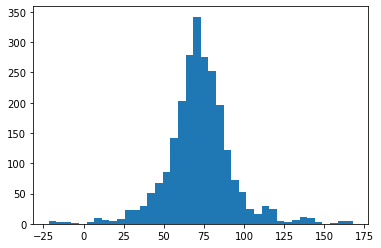

In [85]:
plt.hist(ages, bins=40)

In [86]:
data.describe(percentiles=[.1,.2,.8,.95])

,TIME,feat1,feat2
count,2400.000000,2400.000000,2400.000000
mean,72.438083,0.523105,0.659532
std,10.568790,0.177215,0.199370
min,41.294677,0.099024,0.182119
10%,58.993985,0.274632,0.346676
20%,63.812237,0.353462,0.522657
50%,72.907658,0.526923,0.660768
80%,81.223032,0.697946,0.823750
95%,88.058668,0.792955,1.002674
max,118.624512,0.923628,1.169606


In [87]:
data.to_csv('simulated_study/simulated_data_8/simulated_data_8.csv')
feature_parameters.to_csv('simulated_study/simulated_data_8/true_individual_parameters.csv')

## Save the data 

In [88]:
X = data['TIME'].values
Y = data[['feat1', 'feat2']].values
group = [int(sub) for sub in data.index.values]

In [89]:
np.savetxt('X.csv', X)
np.savetxt('Y.csv', Y, delimiter=',')
np.savetxt('group.csv', group)

In [83]:
data.describe(percentiles=[.1,.2,.3,.5,.7,.8,.9, .95])

,TIME,feat1,feat2
count,800.000000,800.000000,800.000000
mean,71.252696,0.510620,0.655286
std,10.036833,0.189256,0.162464
min,45.421173,0.084783,0.136826
10%,58.891226,0.249743,0.439783
20%,62.573234,0.333949,0.551375
30%,64.859459,0.393284,0.593976
50%,71.445693,0.516825,0.654417
70%,76.979007,0.628455,0.721354
80%,79.929726,0.692023,0.785039


# Simualting other shapes

In [100]:
# logistic sampler from individidual parameters

def parabole(timepoints, acceleration, timeshift, b=1, noise=None):
    """
    - timepoints : real ages of patients at which we want the visits
    - acceleration : feature wise acceleration factor
    - timeshift : feature wise timeshift (point at which the logistic curves hits a fixed value across features)
    - a,b : first asymptote and second asymptote. By default features go from 0 to 1
    """
    res = []
    for time in timepoints:
        if time < timeshift+10:
            res.append(b + 0.015 * np.exp(acceleration) * (time-timeshift-10))
        else:
            res.append(b - 0.001 * np.exp(acceleration) * (time-timeshift-10))
    return res


No handles with labels found to put in legend.


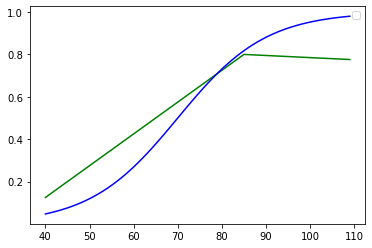

In [101]:
t = np.arange(40,110,1)

#t = np.array([50,50.5,51,52,53])
p1 = parabole(t, 0, 75, 0.8)
p2 = parabole(t, .5, 90, 0.6)
p2 = logistic(t, 0,70)

plt.plot(t,p1,c='g')
plt.plot(t,p2,c='b')
#plt.plot(t,p3,c='r')
plt.legend()
plt.show()


In [102]:
# generation of the individual parameters

n_patients = 100

# individual_parameters
xi_mean = 0
sigma_xi = 0.3
tau_mean = 70
sigma_tau = 15
sources_std = 5

columns = ['xi', 'tau', 'source']
feature_parameters = pd.DataFrame(columns=columns)

for i in range(n_patients):
    xi = np.random.normal(xi_mean, sigma_xi)
    tau = np.random.normal(tau_mean, sigma_tau)
    source = np.random.normal(0,sources_std)
    feature_parameters.loc[i] = [xi, tau, source]
    
feature_parameters.head()

,xi,tau,source
0,-0.175778,57.756733,-1.355890
1,-0.238720,75.642463,6.598268
2,0.116582,85.564649,0.523944
3,0.052802,62.567019,-6.777056
4,-0.424887,81.243040,-4.828926


In [103]:
feature_parameters.describe()

,xi,tau,source
count,100.000000,100.000000,100.000000
mean,-0.048004,70.368737,0.924385
std,0.260868,15.061369,4.978492
min,-0.744761,30.993574,-10.900856
25%,-0.223839,60.936131,-1.629080
50%,-0.049820,69.566739,0.773087
75%,0.123217,79.854951,3.515674
max,0.694650,118.856039,19.841767


In [104]:
# generate the associated trajectories 

visits_per_patients = 5
time_between_visits = 0.5
columns = ['feat1', 'feat2']

data = []
for sub in feature_parameters.index:
    time_first_visit = np.random.normal(loc=70, scale=15)
    #time_first_visit = 50
    timepoints = [time_first_visit + i*time_between_visits for i in range(visits_per_patients)]
    id_params = feature_parameters.loc[sub]
    feature_1 = logistic(np.array(timepoints)-source/2, id_params[0], id_params[1], a=0.2, b=0.8)
    feature_2 = parabole(np.array(timepoints)+source/2, id_params[0], id_params[1], 0.9)

    sub_data = pd.DataFrame([timepoints,feature_1, feature_2]).T
    sub_data.columns = ['TIME', 'feat1', 'feat2']
    sub_data['ID'] = sub
    sub_data = sub_data.set_index(['ID'])
    
    data.append(sub_data)
    
data = pd.concat(data)

In [105]:
data.describe(percentiles=[.1,.2,.8,.95])

,TIME,feat1,feat2
count,500.000000,500.000000,500.000000
mean,74.232142,0.532547,0.709479
std,13.418058,0.184407,0.230161
min,44.208434,0.203052,-0.077608
10%,57.271929,0.233405,0.278952
20%,62.694745,0.360915,0.608271
50%,73.583601,0.538751,0.808576
80%,84.523642,0.722757,0.884959
95%,99.542561,0.792660,0.897120
max,107.328416,0.799820,0.899434


In [106]:
data.to_csv('simulated_data_with_sources_parabole.csv')

## Save the data 

In [107]:
X = data['TIME'].values
Y = data[['feat1', 'feat2']].values
group = [int(sub) for sub in data.index.values]

In [108]:
np.savetxt('X.csv', X)
np.savetxt('Y.csv', Y, delimiter=',')
np.savetxt('group.csv', group)